# architecture-17 ( Basic Classification )

## What's new:

1- Add


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping


# Constants
SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10

2025-07-27 09:52:22.962043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset
df = pd.read_csv('datasets-17/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [3]:
# Scaling Features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

In [4]:

# Label trend reversals (example: a simplistic method)
def label_trend_reversals(prices, window=5):
    labels = []
    for i in range(len(prices) - window):
        past = prices[i:i+window//2]
        future = prices[i+window//2:i+window]
        if np.mean(future) > np.mean(past):
            labels.append(1)  # potential buy
        elif np.mean(future) < np.mean(past):
            labels.append(2)  # potential sell
        else:
            labels.append(0)
    labels += [0] * window  # pad
    return labels

df['Label'] = label_trend_reversals(df['<CLOSE>'].values)


In [5]:
# Prepare Sequences
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(df['Label'].iloc[i:i+FORECAST_HORIZON].values)

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # Debug info

X shape: (55013, 60, 5), y shape: (55013, 10)


In [6]:
# Split Dataset
X_train = X[:-1]
y_train = y[:-1]

# Last 60 candles for prediction
X_input = X[-1:]
y_true_future = y[-1]  # for evaluation if desired


In [7]:
from tensorflow.keras.utils import to_categorical

# One-hot encode each timestep's class (3 classes → depth = 3)
y_onehot = np.array([to_categorical(row, num_classes=3) for row in y_train])
# Now shape = (num_samples, 10, 3)


In [8]:
# Build LSTM Classification Model
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON * 3, activation='softmax'),
    tf.keras.layers.Reshape((FORECAST_HORIZON, 3))
])


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Fit model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.fit(
    X_train,
    y_onehot,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

2025-07-27 09:52:50.879288: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59412000 exceeds 10% of free system memory.


774/774 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.4913 - loss: 0.7727 - val_accuracy: 0.5011 - val_loss: 0.6960
Restoring model weights from the end of the best epoch: 1.


In [11]:
# === Load the last 60 candles from a CSV file ===
input_df = pd.read_csv(
    'datasets-17/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
    sep='\t'
).dropna()

# Combine <DATE> and <TIME> into a datetime column
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

# === Prepare features and scale ===
input_features = input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
input_scaled = scaler.transform(input_features)  # Use the same scaler from training

# Reshape for model: (1, 60, num_features)
input_sequence = np.expand_dims(input_scaled, axis=0)

# === Predict class probabilities ===
pred_probs = model.predict(input_sequence)  # e.g. shape: (1, 10 * 3)
forecast_horizon = 10
pred_classes = np.argmax(pred_probs.reshape(forecast_horizon, 3), axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# === Generate future timestamps ===
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=forecast_horizon, freq='h')

# === Create predicted_df for plotting ===
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# Convert class → label
def class_to_label(c):
    return 'buy' if c == 1 else 'sell' if c == 2 else None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Classes: [2 1 1 1 2 1 1 2 2 1]


# plot section

In [12]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None


In [13]:

import pandas as pd

# === Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=forecast_horizon, freq='h')

# === Create predicted_df with forecasted trend reversals ===
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


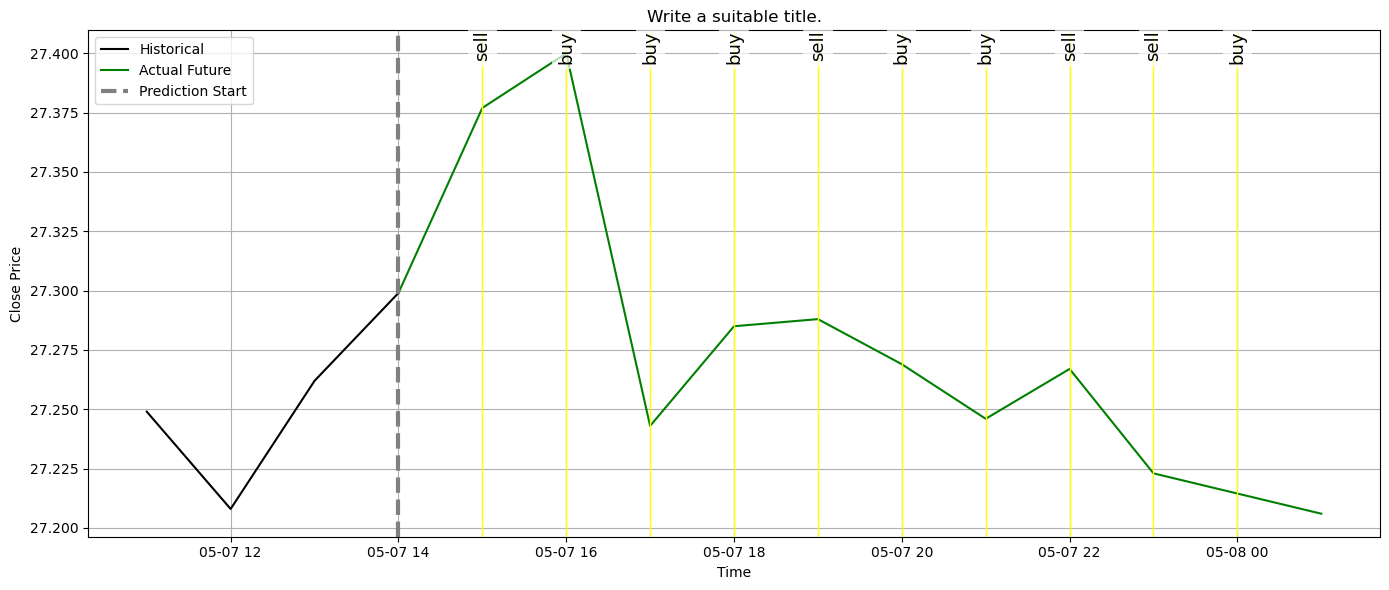

In [14]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)